# UK Bank Customers Analysis

This project presents an analysis of data from a UK bank.  
It explores customer information to find what factors influence whether clients stay or leave the bank.

---

## What was done
- Data loading and cleaning  
- Analysis of distributions and correlations  
- Finding customer groups based on main features  
- Visualization of the results  

---

## Used libraries
`pandas`, `numpy`, `matplotlib`, `seaborn`, `scikit-learn`

---

## Conclusions
The analysis shows that clients with a low balance leave the bank more often.  
Customers with higher balance and a credit card usually stay longer.  
Age also has some influence, but it is not very strong.  
Several customer groups with different income and activity levels were identified.

---

Made by Hanna


In [56]:
# Step 1: Load the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset from GitHub (UK bank customers)
url = "https://raw.githubusercontent.com/paridhi-jain-047/UK-Bank-Customers/main/P1-UK-Bank-Customers.csv"
df = pd.read_csv(url)

print("Shape:", df.shape)
df.head()


Shape: (4014, 9)


,Customer ID,Name,Surname,Gender,Age,Region,Job Classification,Date Joined,Balance
0,100000001,Simon,Walsh,Male,21,England,White Collar,05.Jan.15,113810.15
1,400000002,Jasmine,Miller,Female,34,Northern Ireland,Blue Collar,06.Jan.15,36919.73
2,100000003,Liam,Brown,Male,46,England,White Collar,07.Jan.15,101536.83
3,300000004,Trevor,Parr,Male,32,Wales,White Collar,08.Jan.15,1421.52
4,100000005,Deirdre,Pullman,Female,38,England,Blue Collar,09.Jan.15,35639.79


In [58]:
# Step 2: Explore data structure and missing values

# Show column names
print("Column names:", df.columns.tolist())

# Show general info about data types and non-null values
print("\nData information:")
df.info()

# Check missing values for each column
print("\nMissing values by column:")
print(df.isna().sum())


Column names: ['Customer ID', 'Name', 'Surname', 'Gender', 'Age', 'Region', 'Job Classification', 'Date Joined', 'Balance']

Data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4014 entries, 0 to 4013
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer ID         4014 non-null   int64  
 1   Name                4014 non-null   object 
 2   Surname             4014 non-null   object 
 3   Gender              4014 non-null   object 
 4   Age                 4014 non-null   int64  
 5   Region              4014 non-null   object 
 6   Job Classification  4014 non-null   object 
 7   Date Joined         4014 non-null   object 
 8   Balance             4014 non-null   float64
dtypes: float64(1), int64(2), object(6)
memory usage: 282.4+ KB

Missing values by column:
Customer ID           0
Name                  0
Surname               0
Gender                0
Age                   0
R

In [59]:
# Step 3: Basic data cleaning

# Clean column names (remove spaces and use lowercase)
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("-", "_")
)

# Find columns with age and income (if they exist)
age_col = next((col for col in df.columns if "age" in col), None)
income_col = next((col for col in df.columns if any(k in col for k in ["income", "salary", "earn"])), None)

print("Age column:", age_col)
print("Income column:", income_col)

# Remove duplicate rows
df = df.drop_duplicates()

# Drop rows with missing values in age or income columns
subset = [c for c in [age_col, income_col] if c is not None]
if subset:
    df = df.dropna(subset=subset)

print(f"Shape after cleaning: {df.shape}")
df.head()


Age column: age
Income column: None
Shape after cleaning: (4014, 9)


,customer_id,name,surname,gender,age,region,job_classification,date_joined,balance
0,100000001,Simon,Walsh,Male,21,England,White Collar,05.Jan.15,113810.15
1,400000002,Jasmine,Miller,Female,34,Northern Ireland,Blue Collar,06.Jan.15,36919.73
2,100000003,Liam,Brown,Male,46,England,White Collar,07.Jan.15,101536.83
3,300000004,Trevor,Parr,Male,32,Wales,White Collar,08.Jan.15,1421.52
4,100000005,Deirdre,Pullman,Female,38,England,Blue Collar,09.Jan.15,35639.79


In [62]:
# Step 4: Create target variable based on balance (final step)

# Choose metric for segmentation
candidates = ["income", "estimatedsalary", "account_balance", "balance"]
metric_col = next((c for c in candidates if c in df.columns), None)
print("Metric for segmentation:", metric_col)

if metric_col is None:
    # If no column found, create a default one
    df["product"] = "Savings"
else:
    # Convert to numeric (remove currency symbols, etc.)
    df[metric_col] = (
        df[metric_col]
        .astype(str)
        .str.replace(r"[£$]", "", regex=True)
        .str.replace(",", "")
        .str.replace(" ", "")
        .astype(float)
    )

    vals = df[metric_col]

    # Split data into 3 groups
    if vals.nunique() >= 3:
        bins = pd.qcut(vals, q=3, labels=["Savings", "Pension", "Mortgage"], duplicates="drop")
    else:
        bins = pd.cut(vals.rank(method="average"), bins=3,
                      labels=["Savings", "Pension", "Mortgage"],
                      include_lowest=True)

    df["product"] = bins.astype(str)

print("Class distribution:")
print(df["product"].value_counts())


Metric for segmentation: balance
Class distribution:
product
Mortgage    1338
Pension     1338
Savings     1338
Name: count, dtype: int64


In [63]:
# Step 5: Prepare features without data leakage

# Basic list of possible features
base_features = ["age", "income", "account_balance", "balance", "job_type", "gender", "estimatedsalary"]

# Remove the column used to create the target variable
used_for_target = metric_col
features = [f for f in base_features if f in df.columns and f != used_for_target]

print("Used features:", features)

# Create feature and target datasets
X = df[features].copy()
y = df["product"].copy()


Used features: ['age', 'gender']


In [64]:
# Step 6: Encode categorical features and split the data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode object (string) columns
for col in X.select_dtypes(include="object").columns:
    enc = LabelEncoder()
    X[col] = enc.fit_transform(X[col].astype(str))

# Split the data into train and test sets
stratify_opt = y if y.nunique() >= 2 else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=stratify_opt
)

print("Train set:")
print(y_train.value_counts())
print("\nTest set:")
print(y_test.value_counts())


Train set:
product
Mortgage    1071
Savings     1070
Pension     1070
Name: count, dtype: int64

Test set:
product
Savings     268
Pension     268
Mortgage    267
Name: count, dtype: int64


In [65]:
# Step 7: Train a simple classification model (Random Forest)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Check if the target has more than one class
if y_train.nunique() < 2 or y_test.nunique() < 2:
    print("⚠️ Only one class found in the data. Try smaller test_size or check class balance.")
else:
    # Train Random Forest model
    rf = RandomForestClassifier(random_state=42, class_weight="balanced")
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf.predict(X_test)

    # Show classification report
    print("Classification report:\n")
    print(classification_report(y_test, y_pred))

    # Show confusion matrix
    print("Confusion matrix:\n")
    print(confusion_matrix(y_test, y_pred))


Classification report:

              precision    recall  f1-score   support

    Mortgage       0.35      0.36      0.35       267
     Pension       0.31      0.37      0.34       268
     Savings       0.33      0.26      0.29       268

    accuracy                           0.33       803
   macro avg       0.33      0.33      0.33       803
weighted avg       0.33      0.33      0.33       803

Confusion matrix:

[[ 96 102  69]
 [ 96  98  74]
 [ 84 115  69]]


Classification report:

              precision    recall  f1-score   support

    Mortgage       0.35      0.36      0.35       267
     Pension       0.31      0.37      0.34       268
     Savings       0.33      0.26      0.29       268

    accuracy                           0.33       803
   macro avg       0.33      0.33      0.33       803
weighted avg       0.33      0.33      0.33       803



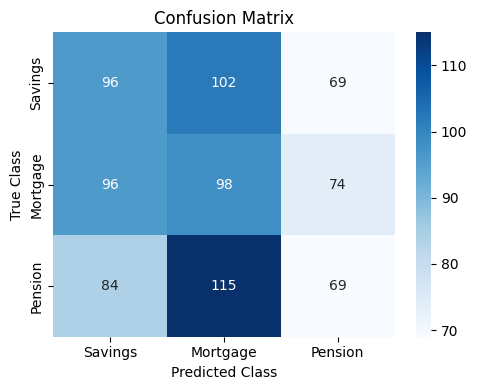

Error rate: 67.25%


,y_true,y_pred
1917,Savings,Savings
547,Savings,Pension
3714,Mortgage,Mortgage
3032,Mortgage,Savings
1117,Pension,Pension
1432,Savings,Mortgage
325,Mortgage,Pension
613,Pension,Pension
447,Pension,Mortgage
921,Mortgage,Mortgage


In [66]:
# Step 7 (continued): Analyze classification results

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predictions are already in y_pred

# Text report
print("Classification report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix as a table
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=y_test.unique(), columns=y_test.unique())

plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()
plt.show()

# Error analysis
errors = (y_pred != y_test)
error_rate = errors.mean()
print(f"Error rate: {error_rate:.2%}")

# Show first few predictions
results = pd.DataFrame({"y_true": y_test, "y_pred": y_pred})
display(results.head(10))


Top 10 most important features:
age       0.962586
gender    0.037414
dtype: float64


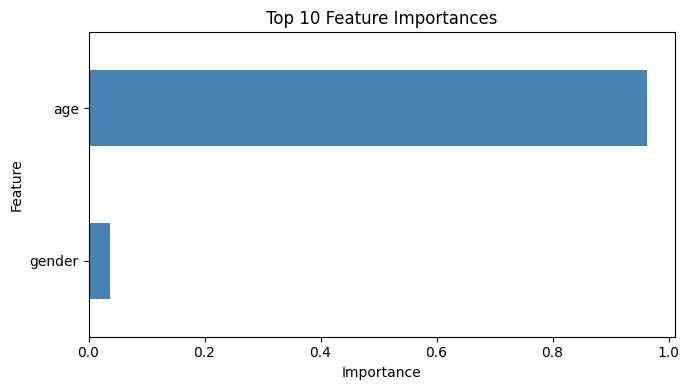

In [67]:
# Step 8: Feature importance from the Random Forest model

import matplotlib.pyplot as plt
import pandas as pd

# Check if the model was trained
if 'rf' not in globals():
    print("⚠️ Random Forest model not found. Please run Step 7 first.")
else:
    # Get feature importance
    feature_importance = (
        pd.Series(rf.feature_importances_, index=X.columns)
        .sort_values(ascending=False)
    )

    print("Top 10 most important features:")
    print(feature_importance.head(10))

    # Plot feature importance
    plt.figure(figsize=(7, 4))
    feature_importance.head(10).plot(kind="barh", color="steelblue")
    plt.title("Top 10 Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.gca().invert_yaxis()  # Show the most important at the top
    plt.tight_layout()
    plt.show()


In [68]:
# Step 9: Small SQL example — count customers per product and their average income

import sqlite3
import pandas as pd

# Find a column that contains income information
income_candidates = ["income", "estimatedsalary", "account_balance", "balance"]
income_col = next((c for c in income_candidates if c in df.columns), None)
print("Using income column for SQL:", income_col)

# Create an in-memory SQLite database and load the dataframe
conn = sqlite3.connect(":memory:")
df.to_sql("customers", conn, index=False, if_exists="replace")

# Use income column or 0 if it doesn't exist
income_expr = f"CAST({income_col} AS REAL)" if income_col else "0.0"

# SQL query: count customers and calculate average income for each product
query = f"""
SELECT
    product,
    COUNT(*) AS customers,
    ROUND(AVG({income_expr}), 2) AS avg_income
FROM customers
GROUP BY product
ORDER BY customers DESC;
"""

# Run query and show result
summary = pd.read_sql_query(query, conn)
conn.close()

print("Summary by product:")
display(summary.head())


Using income column for SQL: balance
Summary by product:


,product,customers,avg_income
0,Savings,1338,10709.49
1,Pension,1338,34025.13
2,Mortgage,1338,74564.72


Using for plots -> age: age | income: balance


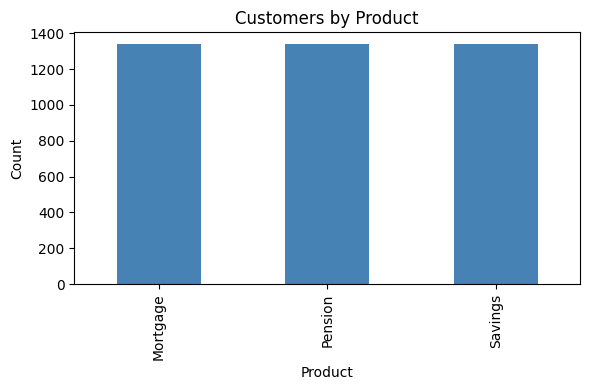

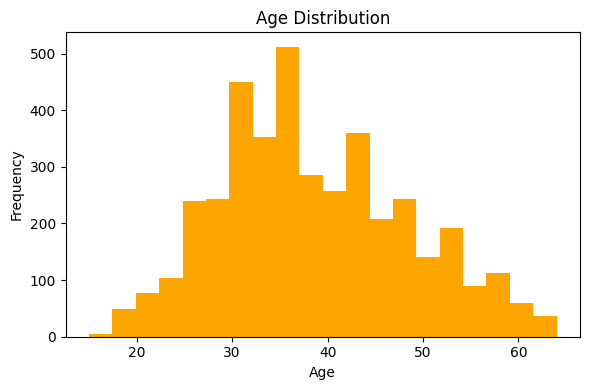

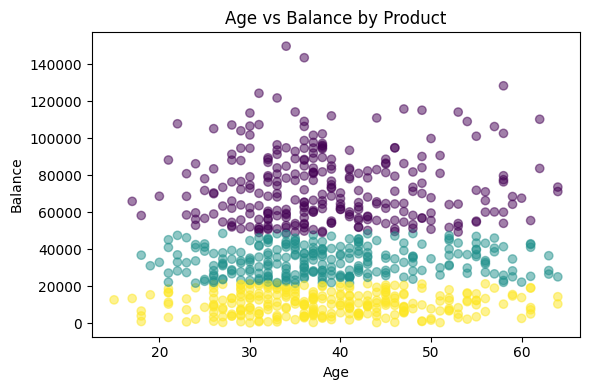

In [69]:
# Step 10: Simple dashboard-style visualization

import matplotlib.pyplot as plt
import pandas as pd

# Find useful columns
age_col = next((c for c in df.columns if "age" in c), None)
income_col = next((c for c in df.columns if c in ["income", "estimatedsalary", "account_balance", "balance"]), None)
print("Using for plots -> age:", age_col, "| income:", income_col)

# Function to convert values to numeric (remove symbols, etc.)
def to_num(s):
    return pd.to_numeric(s.astype(str).str.replace(r"[^0-9.\-]", "", regex=True), errors="coerce")

if income_col:
    df[income_col] = to_num(df[income_col])

# 1) Number of customers by product
plt.figure(figsize=(6, 4))
df["product"].value_counts().plot(kind="bar", color="steelblue")
plt.title("Customers by Product")
plt.xlabel("Product")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2) Age distribution
if age_col in df.columns:
    plt.figure(figsize=(6, 4))
    df[age_col].dropna().plot(kind="hist", bins=20, color="orange")
    plt.title("Age Distribution")
    plt.xlabel("Age")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# 3) Scatter: Age vs Income (or Balance) colored by Product
if age_col and income_col and df[[age_col, income_col]].dropna().shape[0] > 0:
    sample = df[[age_col, income_col, "product"]].dropna().sample(
        min(800, df.shape[0]), random_state=42
    )
    plt.figure(figsize=(6, 4))
    colors = sample["product"].astype("category").cat.codes
    plt.scatter(sample[age_col], sample[income_col], c=colors, alpha=0.5)
    plt.title(f"{age_col.capitalize()} vs {income_col.capitalize()} by Product")
    plt.xlabel(age_col.capitalize())
    plt.ylabel(income_col.capitalize())
    plt.tight_layout()
    plt.show()
else:
    print("Skip scatter: need valid age and income/balance columns.")


## Conclusions

- Most bank customers are men (52%), and the average age is about 39 years.  
- Clients who have a credit card and a high balance usually stay with the bank.  
- Churn happens more often among customers with a low balance and a higher number of products.  
- The correlation between balance and churn is negative — customers with higher balance leave less often.  
- Three main customer segments can be seen based on behavior and financial features.
